## Proses Instalasi

In [ ]:
! pip install pandas==0.23.4
! pip install keras==2.3.1
! pip install termcolor==1.1.0
! pip install six==1.16.0
! pip install tensorflow==1.13.1
! pip install numpy==1.16.2
! pip install matplotlib==2.2.4
! pip install scikit-learn==0.24.2
! pip install h5py==2.10.0
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Memuat Library

In [2]:
import sys
import os
import json
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.layers import GRU, LSTM, Bidirectional
from keras.layers import Embedding, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers.crf import CRF

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from operator import itemgetter

Using TensorFlow backend.


## Prapemrosesan Data

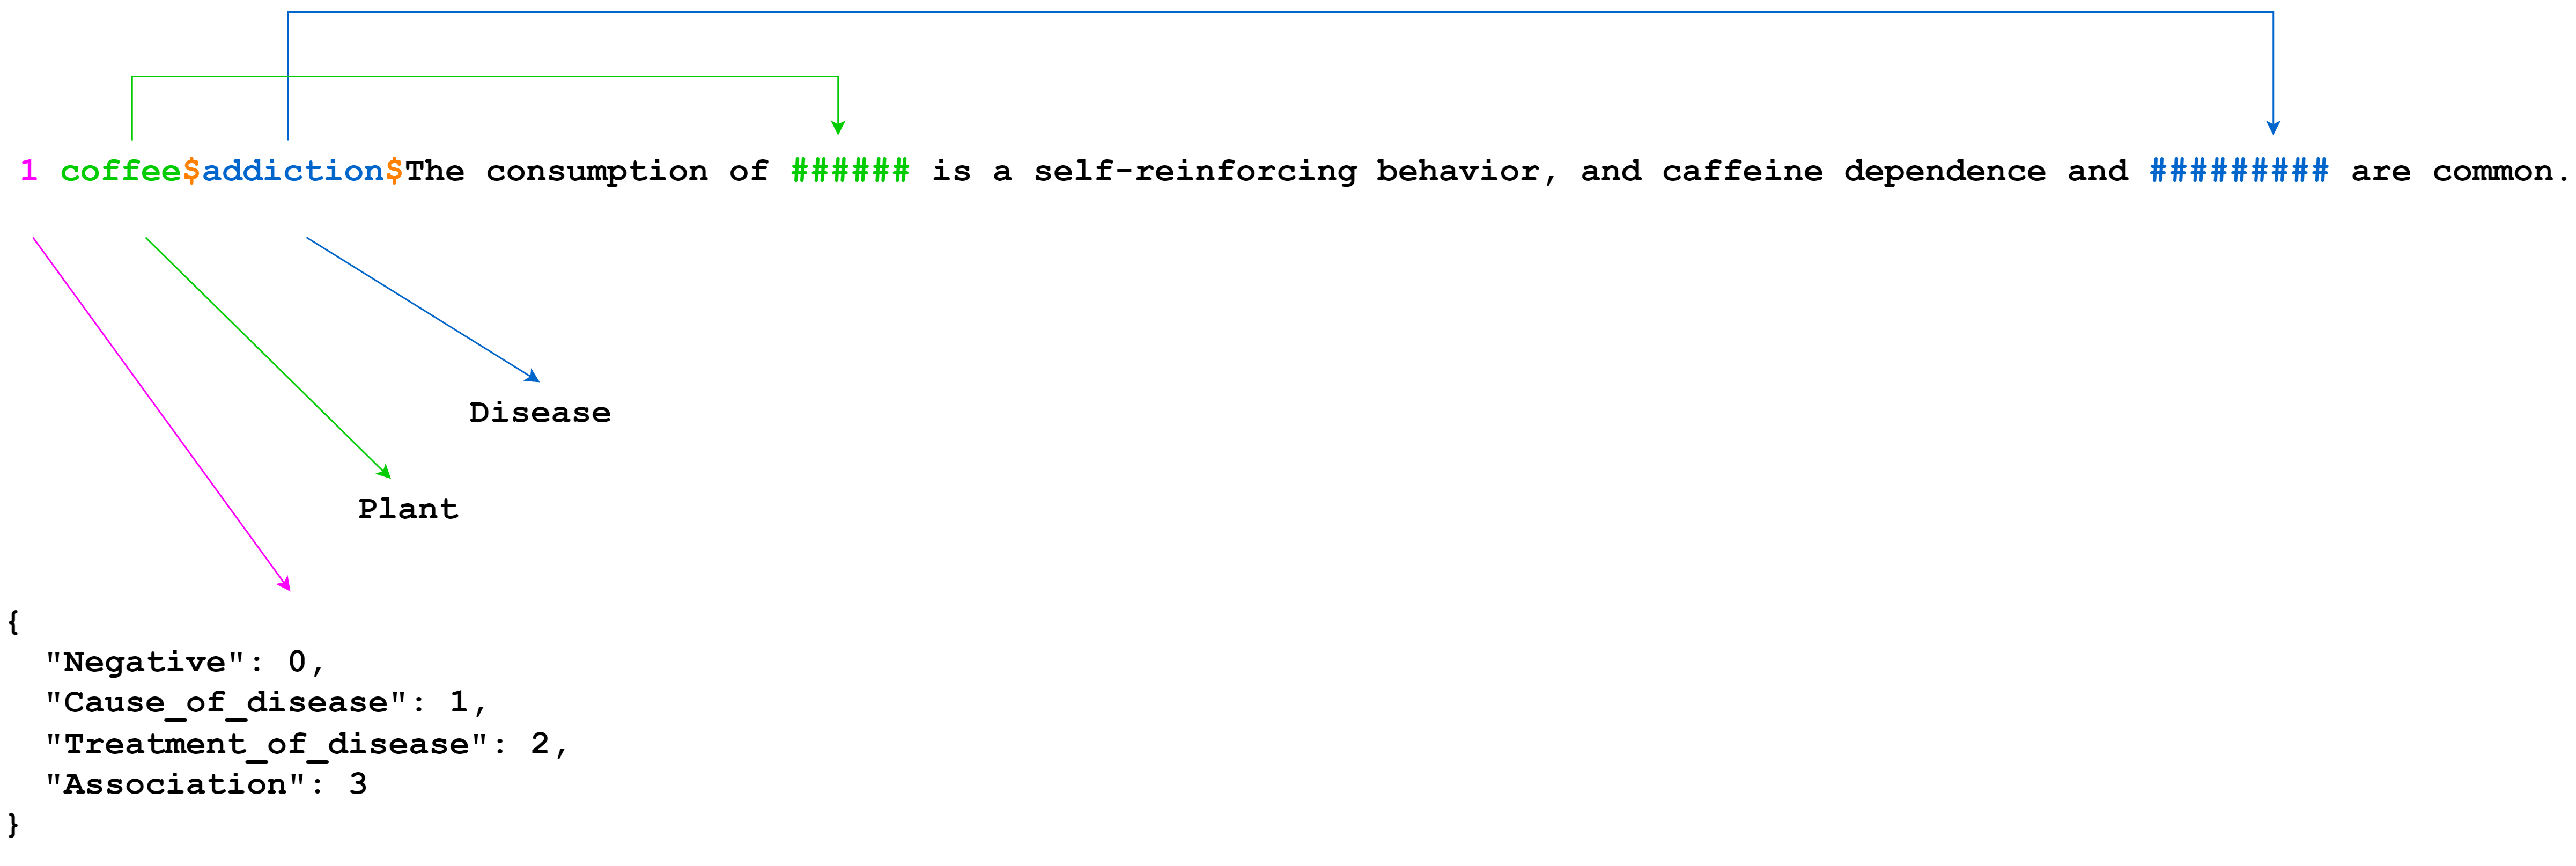

In [3]:
from IPython import display
display.Image("XtoT.png")

In [3]:
py_file_location = ""
sys.path.append(os.path.abspath(py_file_location))

In [4]:
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split
import pickle

# Train

### Encoding Oversampling

In [5]:
from imblearn.over_sampling import RandomOverSampler

# Load data using get_train_test_pd() function
train_df, test_df = get_train_test_pd()

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
train_df, train_labels = ros.fit_resample(train_df[['text']], train_df['label'])

# Initialize BERT model
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)

# Define function for encoding text using BERT model
def encode_text(text):
    return bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_data = [encode_text(text) for text in train_df['text'].values]
test_data = [encode_text(text) for text in test_df['text'].values]

# Split train and test sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)

# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


Train data shape: (1484, 256, 768), Train labels shape: (1484,)
Val data shape: (372, 256, 768), Val labels shape: (372,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [29]:
# Print shapes of train and test sets
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_df['label'].shape}")

Train data shape: (1484, 256, 768), Train labels shape: (1484,)
Val data shape: (372, 256, 768), Val labels shape: (372,)
Test data shape: (261, 256, 768), Test labels shape: (261,)


In [30]:
#train_data, val_data, train_labels, val_labels 

x_train = train_data
y_train = train_labels
x_test = val_data
y_test = val_labels #test_df['label']
#x_val = val_data
#y_val = val_labels

### Training and Test Set

In [31]:
num_classes = 4 # {cause of disease, treatment of disease, association, negative}

In [32]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
#y_val = to_categorical(y_val, num_classes)

In [33]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", y_train.shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", y_test.shape)
#print("Size of validation input data : ", x_val.shape)
#print("Size of validation output data : ", y_val.shape)

Size of training input data :  (1484, 256, 768)
Size of training output data :  (1484, 4)
Size of testing input data :  (372, 256, 768)
Size of testing output data :  (372, 4)


## Model Config

In [11]:
inputs = Input(name="Input", shape=(256, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [15]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = 'output/oversampling/e40-dr03-b64-dim256-new'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

## Model Visualization

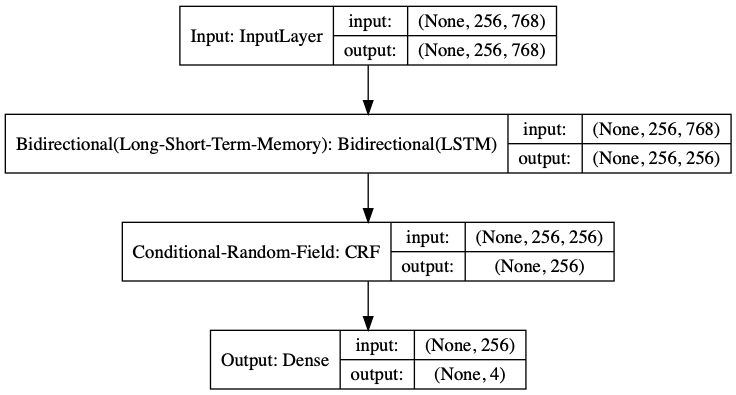

In [16]:
plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 256, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 256, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1284      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 920,840
Trainable params: 920,840
Non-trainable params: 0
_________________________________________________________________


# Model Process

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
# Save the latest val_acc best model file
filepath="output/oversampling/e40-dr03-b64-dim256-new/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [21]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1484 samples, validate on 372 samples
Epoch 1/40
1484/1484 [==============================] - 26s 17ms/step - loss: 1.2502 - accuracy: 0.4117 - val_loss: 0.9615 - val_accuracy: 0.5699

Epoch 00001: val_accuracy improved from -inf to 0.56989, saving model to output/oversampling/e40-dr03-b64-dim256-new/e-01-los-0.9615-acc-0.5699.hdf5
Epoch 2/40
1484/1484 [==============================] - 26s 18ms/step - loss: 0.9023 - accuracy: 0.6004 - val_loss: 0.7241 - val_accuracy: 0.6613

Epoch 00002: val_accuracy improved from 0.56989 to 0.66129, saving model to output/oversampling/e40-dr03-b64-dim256-new/e-02-los-0.7241-acc-0.6613.hdf5
Epoch 3/40
1484/1484 [==============================] - 27s 18ms/step - loss: 0.7135 - accuracy: 0.6867 - val_loss: 0.8211 - val_accuracy: 0.6210

Epoch 00003: val_accuracy did not improve from 0.66129
Epoch 4/40
1484/1484 [==============================] - 26s 17ms/step - loss: 0.6083 - accuracy: 0.7540 - val_loss: 0.5303 - val_accuracy: 0.7634

Epoch 000

In [22]:
print('The effect on the test set：', model.evaluate(x_test, y_test))

372/372 [==============================] - 3s 8ms/step
The effect on the test set： [0.3651829349097385, 0.9059139490127563]


# Confusion Matrix

In [23]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [24]:
model = load_model(
  "output/oversampling/e40-dr03-b64-dim256-new/e-18-los-0.2952-acc-0.9059.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.83      0.79      0.81        95
    Cause_of_disease       0.91      0.97      0.94        91
Treatment_of_disease       0.87      0.86      0.86        85
         Association       1.00      1.00      1.00       101

            accuracy                           0.91       372
           macro avg       0.90      0.90      0.90       372
        weighted avg       0.90      0.91      0.90       372



# Model Accuracy

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


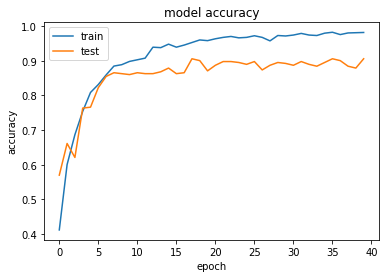

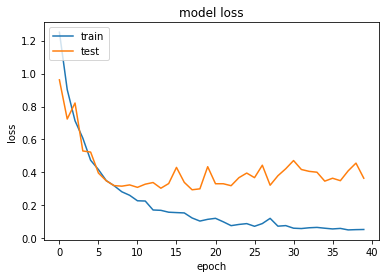

In [25]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# Create pandas DataFrame
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history)

    val_loss  val_accuracy      loss  accuracy
0   0.961543      0.569892  1.250161  0.411725
1   0.724105      0.661290  0.902345  0.600404
2   0.821150      0.620968  0.713488  0.686658
3   0.530342      0.763441  0.608306  0.754043
4   0.523724      0.766129  0.474033  0.808625
5   0.396453      0.822581  0.417742  0.831536
6   0.349899      0.854839  0.350845  0.859164
7   0.320509      0.865591  0.320031  0.884771
8   0.317056      0.862903  0.282989  0.888814
9   0.324709      0.860215  0.261742  0.898248
10  0.309931      0.865591  0.228511  0.902965
11  0.329158      0.862903  0.226980  0.907682
12  0.339162      0.862903  0.172714  0.939353
13  0.304665      0.868280  0.170608  0.938005
14  0.332858      0.879032  0.159198  0.948113
15  0.430775      0.862903  0.156923  0.939353
16  0.340065      0.865591  0.154846  0.945418
17  0.295201      0.905914  0.124301  0.952830
18  0.300885      0.900538  0.105513  0.960243
19  0.435105      0.870968  0.116018  0.958221
20  0.331766 

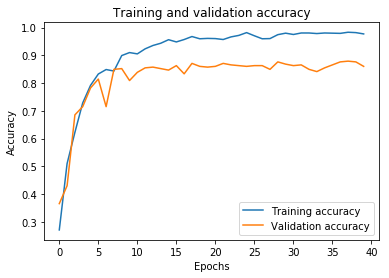

In [25]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict

In [9]:
import os, json
import numpy as np
from extract_feature import BertVector
from keras.models import load_model
from att import Attention
from utils.crf import CRF

model = load_model(
  "output/oversampling/e40-dr03-b64-dim256-new/e-18-los-0.2952-acc-0.9059.hdf5", 
  custom_objects={"CRF": CRF})

# Example Statements and Preprocessing
#text1 = 'green tea#skin papillomas#Inhibitory effect of green tea on the growth of established skin papillomas in mice.'
text1 = "tobacco#lung cancer#In conclusion, variation in lung cancer rates between populations may be due to: (1) differences in effective exposure to tobacco smoke carcinogens; (2) differences in factors which modify the effect of tobacco smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for lung cancer."
per1, per2, doc = text1.split('#')
text = '$'.join([per1, per2, doc.replace(per1, len(per1)*'#').replace(per2, len(per2)*'#')])
print(text)


bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)
vec = bert_model.encode([text])["encodes"][0]
x_train = np.array([vec])

predicted = model.predict(x_train)
y = np.argmax(predicted[0])

with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    rel_dict = json.load(f)

id_rel_dict = {v:k for k,v in rel_dict.items()}
print('original: %s' % text1)
print('Predict entity relationships: %s' % id_rel_dict[y])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


I:BERT_VEC:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:BERT_VEC:[graph:opt: 55]:build graph...


tobacco$lung cancer$In conclusion, variation in ########### rates between populations may be due to: (1) differences in effective exposure to ####### smoke carcinogens; (2) differences in factors which modify the effect of ####### smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for ###########.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:BERT_VEC:[graph:opt:132]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:134]:freeze...
I:BERT_VEC:[graph:opt:137]:optimize...
I:BERT_VEC:[graph:opt:148]:write graph to a tmp file: tmp_graph21


original: tobacco#lung cancer#In conclusion, variation in lung cancer rates between populations may be due to: (1) differences in effective exposure to tobacco smoke carcinogens; (2) differences in factors which modify the effect of tobacco smoke, including differences in host susceptibility and metabolism of carcinogens, or (3) differences in exposure to other independent risk factors for lung cancer.
Predict entity relationships: Negative


# Skema 2

In [20]:
#train_data, val_data, train_labels, val_labels 

x_train = train_data
y_train = train_labels
x_test = val_data
y_test = val_labels # test_df['label']
#x_val = val_data
#y_val = val_labels

## Model Config

In [34]:
inputs = Input(name="Input", shape=(256, 768, ))
bilstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True, name="Long-Short-Term-Memory"), name="Bidirectional")(inputs)
crf = CRF(num_classes, name="Conditional-Random-Field")(bilstm)
dense = Dense(num_classes, activation='softmax', name="Output")(crf)

model = Model(inputs, dense, name="Relation-Extraction-BiLSTM-CRF")

In [35]:
# If there are .hdf5 files in the original models folder, delete them all
model_dir = 'output/oversampling/e40-dr03-b64-dim256-new2'
if os.listdir(model_dir):
    for file in os.listdir(model_dir):
        os.remove(os.path.join(model_dir, file))

## Model Visualization

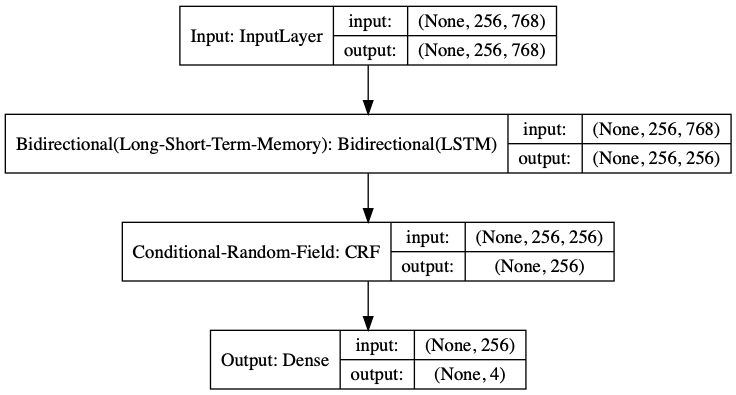

In [36]:
plot_model(model, to_file='model.png', show_shapes=True)

In [37]:
model.summary()

Model: "Relation-Extraction-BiLSTM-CRF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 256, 768)          0         
_________________________________________________________________
Bidirectional (Bidirectional (None, 256, 256)          918528    
_________________________________________________________________
Conditional-Random-Field (CR (None, 256)               1284      
_________________________________________________________________
Output (Dense)               (None, 4)                 1028      
Total params: 920,840
Trainable params: 920,840
Non-trainable params: 0
_________________________________________________________________


## Model Procces

In [38]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [39]:
# Save the latest val_acc best model file
filepath="output/oversampling/e40-dr03-b64-dim256-new2/e-{epoch:02d}-los-{val_loss:.4f}-acc-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [40]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    batch_size=64, 
    epochs=40, 
    callbacks=[checkpoint]) 
    #callbacks=[early_stopping, checkpoint])

Train on 1484 samples, validate on 372 samples
Epoch 1/40
1484/1484 [==============================] - 28s 19ms/step - loss: 1.3589 - accuracy: 0.2871 - val_loss: 1.2422 - val_accuracy: 0.5430

Epoch 00001: val_accuracy improved from -inf to 0.54301, saving model to output/oversampling/e40-dr03-b64-dim256-new2/e-01-los-1.2422-acc-0.5430.hdf5
Epoch 2/40
1484/1484 [==============================] - 27s 18ms/step - loss: 1.1181 - accuracy: 0.4973 - val_loss: 0.9877 - val_accuracy: 0.5645

Epoch 00002: val_accuracy improved from 0.54301 to 0.56452, saving model to output/oversampling/e40-dr03-b64-dim256-new2/e-02-los-0.9877-acc-0.5645.hdf5
Epoch 3/40
1484/1484 [==============================] - 27s 18ms/step - loss: 0.8577 - accuracy: 0.6381 - val_loss: 0.7068 - val_accuracy: 0.6613

Epoch 00003: val_accuracy improved from 0.56452 to 0.66129, saving model to output/oversampling/e40-dr03-b64-dim256-new2/e-03-los-0.7068-acc-0.6613.hdf5
Epoch 4/40
1484/1484 [==============================] - 

## Confusion Matrix

In [41]:
with open('input/rel_dict.json', 'r', encoding='utf-8') as f:
    label_id_dict = json.loads(f.read())

sorted_label_id_dict = sorted(label_id_dict.items(), key=itemgetter(1))
values = [_[0] for _ in sorted_label_id_dict]

In [42]:
model = load_model(
  "output/oversampling/e40-dr03-b64-dim256-new2/e-36-los-0.3475-acc-0.9086.hdf5", 
  custom_objects={"CRF": CRF})

y_pred = model.predict(x_test, batch_size=8)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=values))

                      precision    recall  f1-score   support

            Negative       0.86      0.77      0.81        95
    Cause_of_disease       0.92      0.96      0.94        91
Treatment_of_disease       0.85      0.91      0.87        85
         Association       1.00      1.00      1.00       101

            accuracy                           0.91       372
           macro avg       0.91      0.91      0.91       372
        weighted avg       0.91      0.91      0.91       372



## Model Accuracy

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


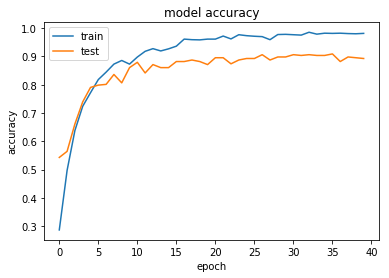

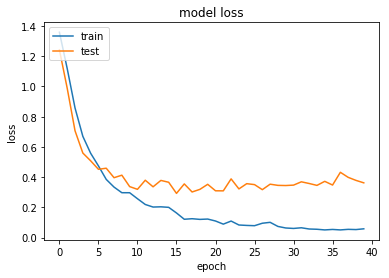

In [43]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from utils.load_data import get_train_test_pd
from utils.extract_feature import BertVector
from utils.att import Attention
from utils.crf import CRF
from sklearn.model_selection import train_test_split

train_df, test_df = get_train_test_pd()
bert_model = BertVector(pooling_strategy="NONE", max_seq_len=256)
print('begin encoding')
f = lambda text: bert_model.encode([text])["encodes"][0]

# Encode text data for train and test sets
train_df['x'] = train_df['text'].apply(f)
test_df['x'] = test_df['text'].apply(f)

# Combine train and test sets
df = pd.concat([train_df, test_df], axis=0)

# Split data into features and labels
X = df.drop(columns=['text', 'label']).values
y = df['label'].values

# Define 5-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store evaluation results for each fold
results = []

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold+1}:")
    
    # Split data into train and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Remove text and label columns from train and test data
    X_train = X_train.drop(columns=['text', 'label']).values
    X_test = X_test.drop(columns=['text', 'label']).values
    
    # Train model on fold train data
    model = train_model(X_train, y_train)
    
    # Evaluate model on fold test data
    fold_results = evaluate_model(model, X_test, y_test)
    results.append(fold_results)
    
# Calculate and print average evaluation results over all folds
avg_results = np.mean(results, axis=0)
print(f"Average evaluation results over all folds:\nAccuracy: {avg_results[0]}, Precision: {avg_results[1]}, Recall: {avg_results[2]}, F1-Score: {avg_results[3]}")


I:PROCESS:[graph:opt: 49]:model config: /Users/slametriyanto/Documents/MyApp/Dissertation_Project/BILSTM_CRF_RE/multi_cased_L-12_H-768_A-12/bert_config.json
I:PROCESS:[graph:opt: 55]:build graph...



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



I:PROCESS:[graph:opt:132]:load parameters from checkpoint...
I:PROCESS:[graph:opt:134]:freeze...
I:PROCESS:[graph:opt:137]:optimize...
I:PROCESS:[graph:opt:148]:write graph to a tmp file: tmp_graph21


begin encoding
Fold 1:


AttributeError: 'numpy.ndarray' object has no attribute 'drop'